In [1]:
from __future__ import print_function

# Genomics example

This will explore how importance scores from three different methods compare on simulated genomic data.

The simulated data was as follows:
- 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded (see http://compbio.mit.edu/encode-motifs/ for the PWM); these were labelled 1,0,0
- 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,1,0
- 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
- 1/4 sequences with no motif

Scores for all three tasks for sequences that contain both TAL1_known1 and GATA_disc1 motifs are analyzed in this notebook

## Obtain data and keras model

We will download genomic data and model

### Download the data and model

In [2]:
!./grab_model_and_data.sh

File sequences.simdata.gz exists already
File record_5_model_PQzyq_modelJson.json exists already
File record_5_model_PQzyq_modelWeights.h5 exists already
File test.txt.gz exists already


### Read in and one-hot encode the data

The simdna package is needed for reading the data; install it if it doesn't exist

In [3]:
try:
    import simdna
except ImportError, e:
    print("installing simdna package")
    !pip install -e "git://github.com/kundajelab/simdna.git@0.4.0#egg=simdna"
    print("\n******************************************************************************")
    print("RESTART THE JUPYTER KERNEL TO PICK UP ON THE INSTALLATION!!!")
    print("******************************************************************************")

Read in the data

In [4]:
import simdna.synthetic as synthetic
reload(synthetic)
reload(synthetic.core)
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

One-hot encode the data

In [5]:
import numpy as np

#this model was trained on data one-hot encoded as a 2d image, with the row-axis being the axis
#for one-hot encoding.
def one_hot_encode_along_row_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((1,4,len(sequence)), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return[0],
                                 sequence=sequence, one_hot_axis=0)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #zeros_array should be an array of dim 4xlen(sequence), filled with zeros.
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_row_axis(seq) for seq in data.sequences])

### Load the keras model

In [6]:
import deeplift
import deeplift.conversion.keras_conversion as kc

#load the keras model
keras_model_weights = "record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "record_5_model_PQzyq_modelJson.json"

keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  json=keras_model_json)

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
Using Theano backend.


## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT (with 3 different variants: rescale on the conv layers and revealcancel on the fully-connected layers (the genomics default), rescale on all layers, and revealcancel on all layers), gradients and guided backprop

In [7]:
from deeplift.blobs import NonlinearMxtsMode
from collections import OrderedDict

method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    #The genomics default = rescale on conv layers, revealcance on fully-connected
    ('rescale_conv_revealcancel_fc', NonlinearMxtsMode.DeepLIFT_GenomicsDefault),
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_sequential_model(
        model=keras_model,
        nonlinear_mxts_mode=nonlinear_mxts_mode)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv2D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv2D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
nonlinear_mxts_mode is set to: Rescale
nonlinear_mxts_mode is set to: RevealCancel
nonlinear_mxts_mode is set to: Gradient
nonlinear_mxts_mode is set to: GuidedBackprop


### Sanity checks

To ensure that the conversion happend correctly, ensure that the models give identical predictions

In [8]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
model_to_test = method_to_model['rescale_conv_revealcancel_fc']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions

Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [9]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
#To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_conv_revealcancel_fc
Compiling scoring function for: rescale_all_layers
Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


### Call scoring functions on the data

In the cell below, a reference representing 40\% GC content is used

In [10]:
background = OrderedDict([('A', 0.3), ('C', 0.2), ('G', 0.2), ('T', 0.3)])

from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0,1,2]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[onehot_data],
                    input_references_list=[
                     np.array([background['A'],
                               background['C'],
                               background['G'],
                               background['T']])[None,None,:,None]],
                    batch_size=200,
                    progress_update=None))
        assert scores.shape[2]==4
        scores = np.squeeze(np.sum(scores, axis=2),axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_conv_revealcancel_fc
on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


## Using multiple shuffled references

As an alternative to using a flat reference based on GC content (which can sometimes produce artefacts), we propose averaging the scores produced using mutliple references which are produced by shuffling the original sequence. We find in practice that this can give more robust results. Not that in general, the optimal choice of reference is an area of active research.

In [11]:
reload(deeplift.util)
from deeplift.util import get_shuffle_seq_ref_function
#from deeplift.util import randomly_shuffle_seq
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

rescale_conv_revealcancel_fc_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=method_to_scoring_func['rescale_conv_revealcancel_fc'],
    #shuffle_func is the function that shuffles the sequence
    #technically, given the background of this simulation, randomly_shuffle_seq
    #makes more sense. However, on real data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_row_axis(seq) for seq in x]))

num_refs_per_seq=10 #number of references to generate per sequence
method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)] = OrderedDict()
for task_idx in [0,1,2]:
    method_to_task_to_scores['rescale_conv_revealcancel_fc_multiref_'+str(num_refs_per_seq)][task_idx] =\
        np.squeeze(np.sum(rescale_conv_revealcancel_fc_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=data.sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=200,
            progress_update=1000,
        ),axis=2))

1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
1000 reference seqs generated
2000 reference seqs generated
3000 reference seqs generated
4000 reference seqs generated
5000 reference seqs generated
6000 reference seqs generated
7000 reference seqs generated
8000 reference seqs generated
One hot encoding

## Visualize scores on individual sequences

Visualize the scores at specific sequences. Cyan boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs, red boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs

Scores for task 0 for example 731
grad_times_inp


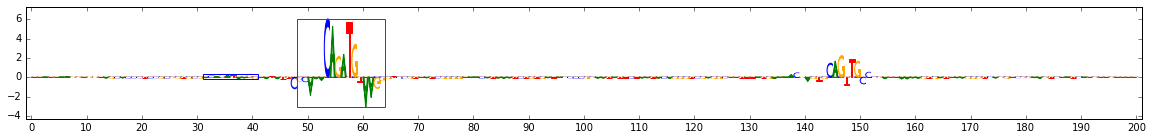

guided_backprop


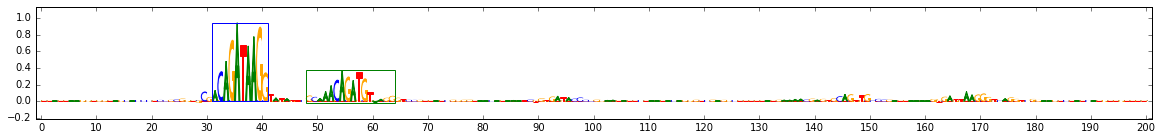

integrated_gradients10


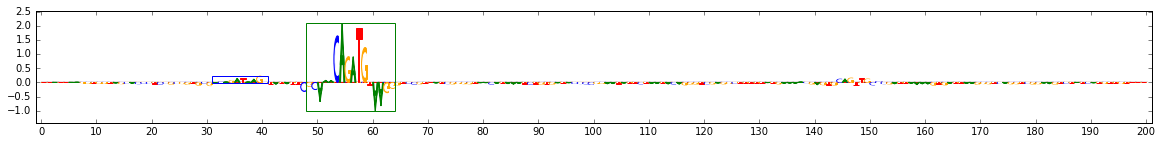

rescale_all_layers


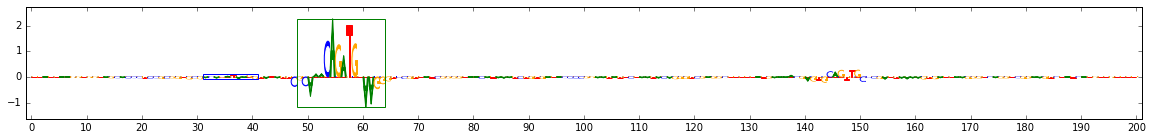

revealcancel_all_layers


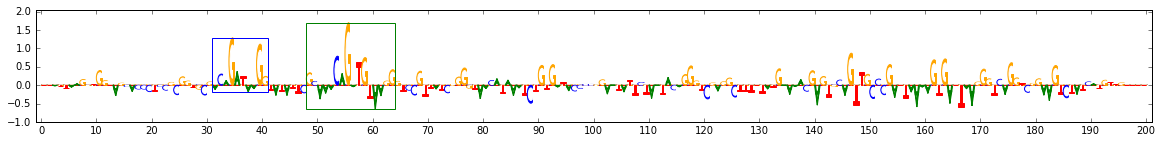

rescale_conv_revealcancel_fc


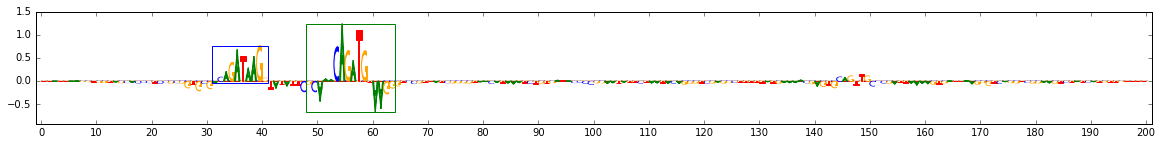

rescale_conv_revealcancel_fc_multiref_10


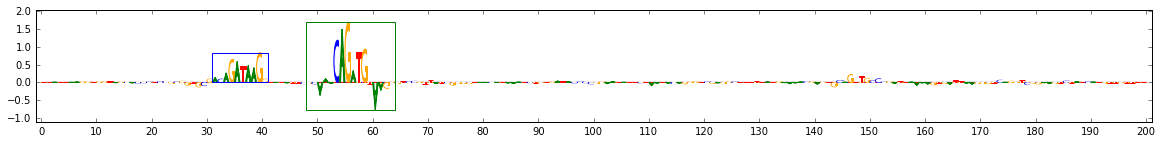

Scores for task 1 for example 197
grad_times_inp


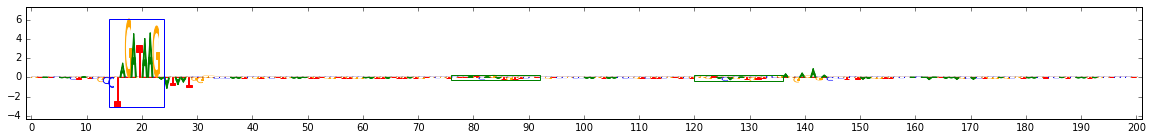

guided_backprop


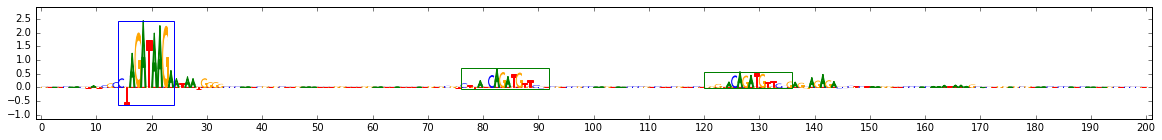

integrated_gradients10


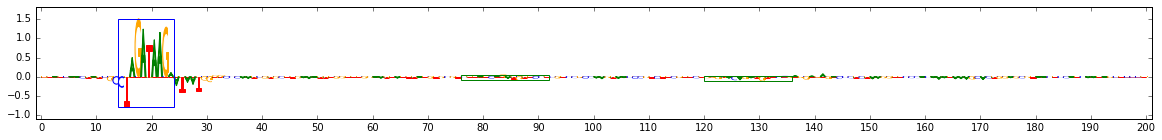

rescale_all_layers


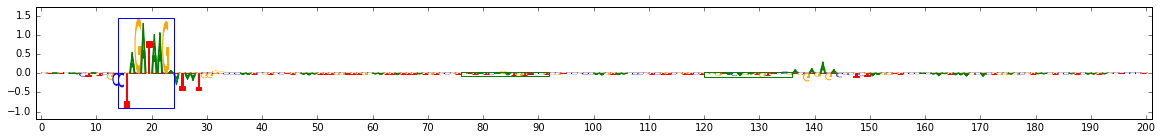

revealcancel_all_layers


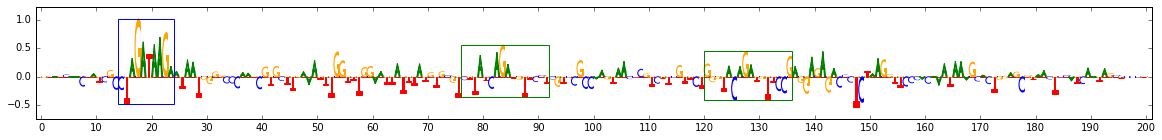

rescale_conv_revealcancel_fc


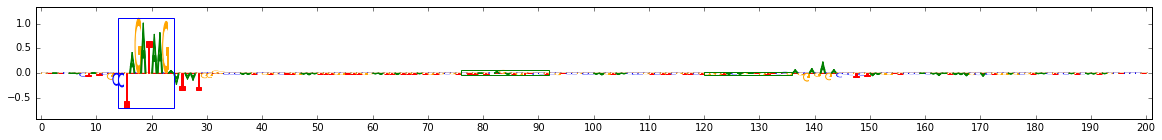

rescale_conv_revealcancel_fc_multiref_10


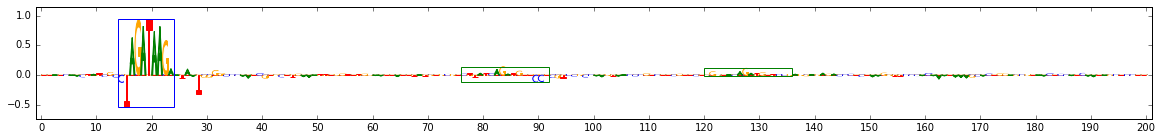

In [12]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import viz_sequence

for task, idx in [(0,731), #illustrates failure of grad*inp, integrated grads, deeplift-rescale
                  (1,197)  #illustrates non-specific firing of guided backprop
                 ]:
    print("Scores for task",task,"for example",idx)
    for method_name in [
                        'grad_times_inp',
                        'guided_backprop',
                        'integrated_gradients10',
                        'rescale_all_layers', 'revealcancel_all_layers',
                        'rescale_conv_revealcancel_fc',
                        'rescale_conv_revealcancel_fc_multiref_10'
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_onehot = onehot_data[idx]
        scores_for_idx = original_onehot*scores_for_idx[None,None,:]
        print(method_name)
        highlight = {'blue':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'GATA_disc1' in embedding.what.getDescription()],
                'green':[
                (embedding.startPos, embedding.startPos+len(embedding.what))
                for embedding in data.embeddings[idx] if 'TAL1_known1' in embedding.what.getDescription()]}
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight=highlight)

## Scatterplots of motif strength vs. importance scores

Visualizing the results on individual examples is one thing, but how can we get a sense of the performance across all examples? Fortunately, because we simulated the data, we know the true PWMs that the motif instances were sampled from. Thus, for every sequence, we can identify the top 5 matches to a given PWM and also investigate the total importance assigned to the positions underlying those matches. Depending on the task and the particular sequence, we should find that strong matches to certain PWMs are very relevant for some tasks and not relevant for others. The code for performing that analysis is given below.

### Find the top motif matches and the strength of the scores underlying them

Scores are computed for different tasks, and using different methods

In [26]:
import matplotlib.pyplot as plt
import simdna
from simdna import synthetic as sn
%matplotlib inline

#dictionary mapping the name of the motif to the strength of the top N matches per sequence
motif_to_top_N_log_odds_scores = OrderedDict()
#dictionary mapping the name of the motif to the incides of the top N matches per sequence
motif_to_top_N_indices = OrderedDict()
#dictionary mapping the name of the motif to a
# [dictionary mapping the task to a
#  [ dictionary mapping the method name to the total score atop the corresponding top N motif matches]]
motif_to_task_to_method_to_corresponding_score = OrderedDict()

for motif_name in ['GATA_disc1', 'TAL1_known1']:
    #get the motif locations
    #load a file representing the full set of ENCODE motifs
    loaded_motifs = sn.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH,
                                        pseudocountProb=0.001)
    #get the PWM
    pwm_rows = loaded_motifs.getPwm(motif_name).getRows()
    
    #convert PWM to a log-odds matrix
    log_odds_mat = np.log(pwm_rows) - np.log(np.array([background['A'], background['C'], background['G'], background['T']])[None,:])
    #transpose it so ACGT is on the first axis
    log_odds_mat = log_odds_mat.T
    #compile a function that will do the cross-correlation with the log-odds matrix
    cross_corr_func = deeplift.util.get_cross_corr_function(filters=np.array([log_odds_mat]))
    #get the scores using the cross-correlation with the log-odds matrix
    log_odds_scores = np.squeeze(cross_corr_func(onehot_data, batch_size=20))
    #log-odds matrix was transposed, so now the length of the motif is the second dim
    motif_size = log_odds_mat.shape[-1] 
    
    #for reach region, retain top n non-overlapping log-odds scores (here n=5)
    #the top n hits are selected greedily; every time a hit location is found, other
    #hits within exclude_hits_within_window are ignored. This is to prevent overlapping
    #hits from being returned.
    #top_n_log_odds_scores returns the top n scores per region.
    #top_n_indices returns the indices (location within the sequence; left edge) at which the hits were found
    top_n_log_odds_scores, top_n_indices = deeplift.util.get_top_n_scores_per_region(
        log_odds_scores, n=5, exclude_hits_within_window=int(motif_size/2))
    
    #store the hits and their locations in the dictionaries
    motif_to_top_N_log_odds_scores[motif_name] = top_n_log_odds_scores
    motif_to_top_N_indices[motif_name] = top_n_indices
    
    #now compile the values for the total score at those motif hits for different tasks, using different methods
    task_to_method_to_corresponding_score = OrderedDict()
    motif_to_task_to_method_to_corresponding_score[motif_name] = task_to_method_to_corresponding_score
    
    #get the scores for different tasks
    for task_idx, task_description in [
        (0, "0 (both-tal-and-gata)"),
        (1, '1 (gata-only)'),
        (2, '2 (tal-only)')]:
        
        task_to_method_to_corresponding_score[task_idx] = OrderedDict()
    
        #iterate over different methods
        for method in method_to_task_to_scores:
            
            scores = method_to_task_to_scores[method][task_idx]
            #the smoothen function averages scores within a window of size motif_size
            #same_size_return=False just means we don't want to bother with padding the arrays to make
            #sure that the returned array is the same size as the supplied array
            #when this smoothen function is called, the value at index i represents the average
            #scores for the indices i:i+motif_size
            smoothen_function = deeplift.util.get_smoothen_function(motif_size, same_size_return=False)
            #we want the total scores on top of the hits, not the average scores, so we scale up the results of calling
            #the smoothen function by motif_size
            sum_scores = np.array(smoothen_function(scores, batch_size=20))*motif_size #scale it up            
            
            #Finally, we just index into sum_scores according to the locations of the top n motif
            #hits to retrieve the total score atop those motif hits
            corresponding_sum_scores = []
            for scores_this_region, indices in zip(sum_scores, top_n_indices):
                corresponding_sum_scores.append([scores_this_region[idx] for idx in indices])
            
            task_to_method_to_corresponding_score[task_idx][method] = np.array(corresponding_sum_scores)

### Make the scatterplots

Note that there may be minor differences between these figures and the one in the paper because the figures in the paper were generated on the validation set, while here for simplicity we generate the figures on the testing set

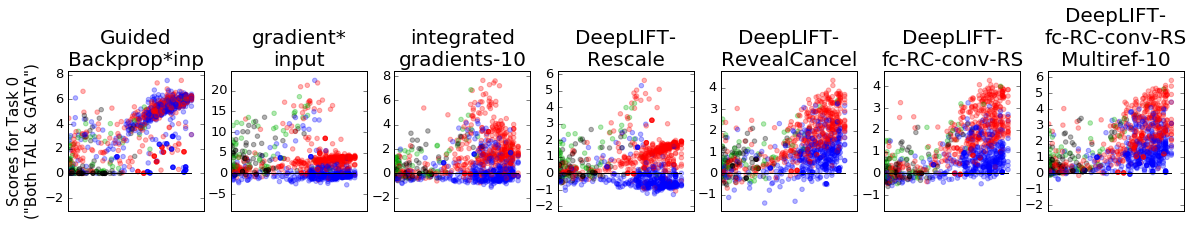

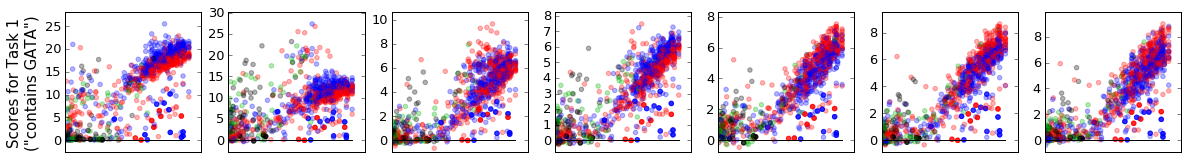

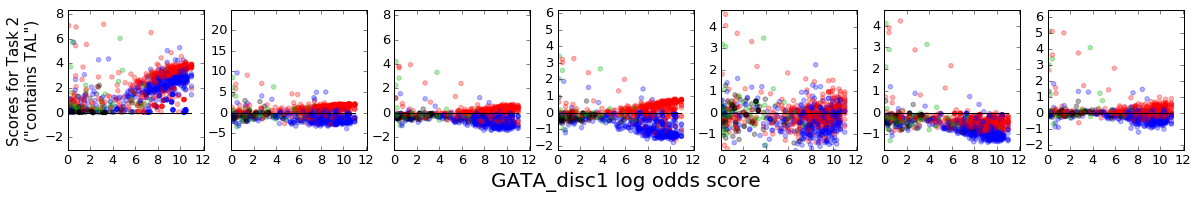

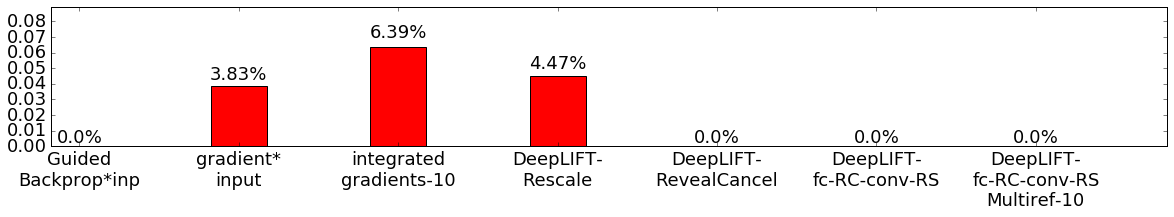

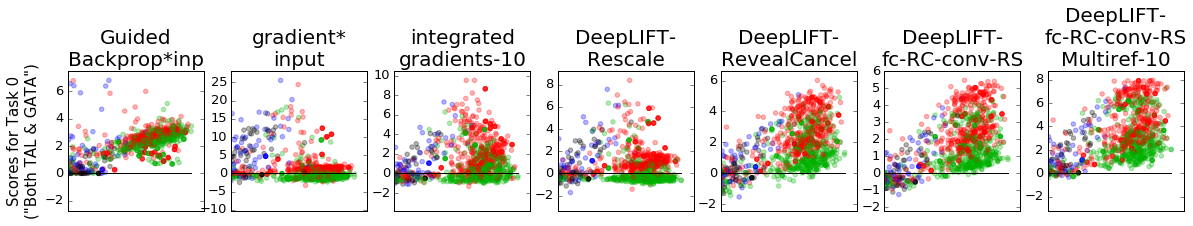

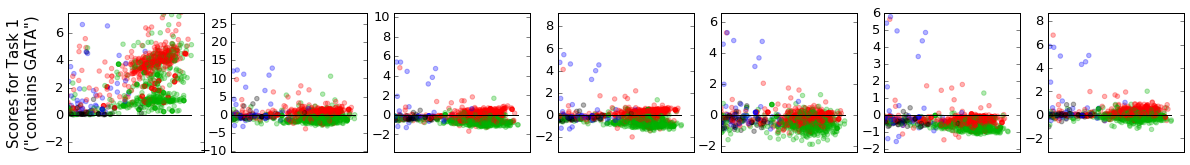

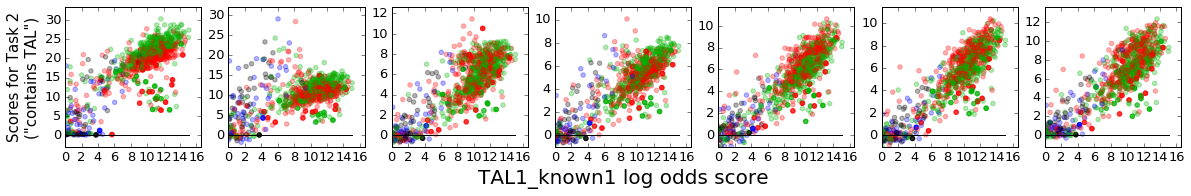

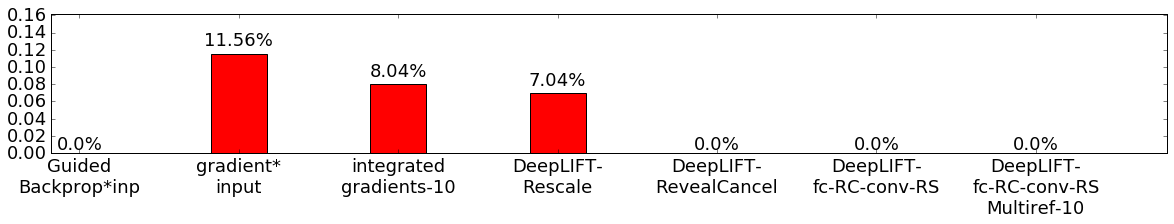

In [27]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

#compile a list of the methods to make the plots for
methods_and_names = [
        ('guided_backprop', 'Guided\nBackprop*inp'),
        ('grad_times_inp', 'gradient*\ninput'),
        ('integrated_gradients10', 'integrated\ngradients-10'),
        ('rescale_all_layers', 'DeepLIFT-\nRescale'),
        ('revealcancel_all_layers', 'DeepLIFT-\nRevealCancel'),
        ('rescale_conv_revealcancel_fc', 'DeepLIFT-\nfc-RC-conv-RS'),
        ('rescale_conv_revealcancel_fc_multiref_10', 'DeepLIFT-\nfc-RC-conv-RS\nMultiref-10')
    ]

#function to randomly shuffle the input arrays (correspondingly)
def shuffle_arrays(arrs):
    if len(arrs) == 0:
        raise ValueError("should supply at least one input array")
    len_of_arrs = len(arrs[0])
    #sanity check that all lengths are equal
    for arr in arrs:
        if (len(arr) != len_of_arrs):
            raise ValueError("First supplied array had length "
                             +str(len_of_arrs)
                             +" but a subsequent array had length "
                             +str(len(arr)))
    for i in xrange(0,len_of_arrs):
        #randomly select index:
        chosen_index = random.randint(i,len_of_arrs-1)
        for arr in arrs:
            #swap
            val_at_index = arr[chosen_index]
            arr[chosen_index] = arr[i]
            arr[i] = val_at_index
    return arrs

#iterate over the two motifs
for motif_name in ['GATA_disc1', 'TAL1_known1']:
    #method_to_task_0_max_y is used so that the scale used for task 0 is
    #also applied to the task for which the motif is irrelevant
    #(irrelevant = task 2 for GATA and task 1 for TAL)
    #This makes it easier to tell, by eye, whether the method has a 
    #tendency to produce false positives.
    method_to_task_0_max_y = OrderedDict()
    #frac_task_0_red_le_zero is the fraction of high-scoring motifs
    #in regions that had both an embedded TAL and an embedded GATA that
    #were given importance of < 0 (false negatives)
    frac_task_0_red_le_zero = OrderedDict()
    
    #iterate over all three tasks
    for task_idx, task_description in [
        (0, '("Both TAL & GATA")'),
        (1, '("contains GATA")'),
        (2, '("contains TAL")')]:

        fig = plt.figure(figsize=(20,2.5))

        for method_num, (method, name) in enumerate(methods_and_names):
            #In the subplot of dimensions 1xlen(methods_and_names), select
            #the method_num+1 subplot to work with (is 1-indexed so works out)
            ax = plt.subplot(1,len(methods_and_names),method_num+1)
            
            scatter_plot_x = [] #x-coordinates for scatter plot
            scatter_plot_y = [] #y-coordinates for scatter plot
            colors = [] #colors of the points
            
            #iterate over possible label combinations for all three tasks
            #(different label combinations get colored differently)
            #(0,0,0) = no motifs = black
            #(0,1,0) = only GATA inserted = blue
            #(0,0,1) = only TAL inserted = green
            #(1,1,1) = both TAL and GATA inserted = red
            for labels,alpha,color,legend_label in [[(0,0,0), 0.3, (0,0,0), 'empty'],
                                                    [(0,1,0), 0.3, (0,0,1), 'gata only'],
                                                    [(0,0,1), 0.3, (0,0.7,0), 'tal only'],
                                                    [(1,1,1), 0.3, (1,0,0), 'gata & tal']]:
                #indices_to_keep_mask hones in on only those regions that
                #satisfy the label combination in question
                indices_to_keep_mask = [
                    True if (x[0]==labels[0] and x[1]==labels[1] and x[2]==labels[2])
                    else False for x in data.labels]
                #get the motif scores in only the regions that satisfy the
                #label combination of interest
                log_odds_scores = np.compress(
                    condition=indices_to_keep_mask,
                    a=motif_to_top_N_log_odds_scores[motif_name],
                    axis=0)
                #as well as the importance scores on only the regions that satisfy the
                #label combination of interest
                sum_scores = np.compress(
                    condition=indices_to_keep_mask,
                    a=motif_to_task_to_method_to_corresponding_score[motif_name][task_idx][method],
                    axis=0)
                
                #compile the motif log-odds scores and the corresponding importance scores into
                #a two-dimensional array for all cases where the motif log-odds score is > 0
                #(the cases where the motif log-odds score is < 0 can get very noisy because strong positive
                # matches to a particular motif register as very strong negative matches to
                # other motifs and can thus still have high importance scores)
                scatter_plot_coords =\
                 np.array([x for x in zip(log_odds_scores.ravel(), sum_scores.ravel()) if x[0] > 0])
                #extract the x and y indices into their separate arrays, as we will need to shuffle
                #this so that datapoints of one color don't completely dominate other colors
                scatter_plot_x.extend(scatter_plot_coords[:,0])
                scatter_plot_y.extend(scatter_plot_coords[:,1])
                colors.extend([color for i in range(len(scatter_plot_coords))])

                #also keep track of the fraction of cases where both TAL and GATA were present in the
                #sequence but a strong match to the motif got < 0 importance (false negatives)
                if (task_idx == 0 and labels==(1,1,1)):
                    threshold = 7
                    red_zeros_picked_out= [(x, y) for x,y in
                                            zip(scatter_plot_coords[:,0], scatter_plot_coords[:,1])
                                            if (y <= 0) and (x >= threshold)]
                    frac_task_0_red_le_zero[name] = float(len(red_zeros_picked_out))/len([x for x in scatter_plot_coords[:,0] if x >= threshold])

            #shuffle the points so that datapoints of one color don't completely
            #dominate other colors
            shuffle_arrays([scatter_plot_x, scatter_plot_y, colors])
            #make the plot
            the_plot = ax.scatter(scatter_plot_x, scatter_plot_y,
                                  alpha=alpha, color=colors)
            
            #add in labels where appropriate (the if statements are so that the labels don't
            #get added to every single plot, but only at the edges)
            if (method_num==0):
                ax.set_ylabel("Scores for Task "+str(task_idx)+"\n"+task_description, fontsize=15)
            if (method_num==int(len(methods_and_names)/2) and task_idx==2):
                ax.set_xlabel(motif_name+" log odds score", fontsize=20)
            if (task_idx!=2):
                ax.set_xticks([])
            ax.tick_params(axis='both', which='major', labelsize=13)
            if (task_idx==0):
                ax.set_title(name, fontsize=20)

            #Setting the y-axes
            #The thing to note here is that we use the same scale as task 0 for the "off" task
            #the 'off' task is task 1 for TAL or task 2 for GATA. This makes it easier to
            #judge if the method has a tendency to produce false positives.
            max_y = np.max(np.abs(scatter_plot_y))
            if (task_idx == 0):
                method_to_task_0_max_y[method] = max_y
            if ((task_idx==1 and motif_name=="TAL1_known1") or (task_idx==2 and motif_name=="GATA_disc1")):
                max_y = method_to_task_0_max_y[method]            
            
            if ((task_idx==1 and motif_name=="GATA_disc1") or (task_idx==2 and motif_name=="TAL1_known1")):
                ax.set_ylim((-0.1*max_y, 1.1*max_y))
            else:
                ax.set_ylim((-0.4*max_y, 1.1*max_y))
                
            ax.set_xlim(0, np.max(scatter_plot_x)*1.1)
            ax.plot([0,np.max(scatter_plot_x)], [0,0], color="black")

    #plot stuff!
    plt.show()
    
    #also make a barplot of the fraction of "false negatives"
    fig,ax = plt.subplots(figsize=(20,2.5))
    ind = np.arange(len(frac_task_0_red_le_zero.values()))
    width=0.35
    heights = np.array(frac_task_0_red_le_zero.values())
    rects = ax.bar(ind, heights, width, color='red')
    ax.set_xticks(ind + 0.5*width)
    ax.set_xticklabels(frac_task_0_red_le_zero.keys(),fontsize=14)
    ax.set_ylim(0, max(heights)*1.4)
    plt.tick_params(labelsize=18)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,
                1.05*height, str(round(100*height,2))+"%",
                ha='center', va='bottom', fontsize=18)
    plt.show()